In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn import preprocessing
from joblib import dump

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

images_path = '../input/rdocuments/rdocuments/'
csv_path = '../input/rdocuments/r-images.csv'

IMG_WIDTH, IMG_HEIGHT = 316, 316
BATCH_SIZE = 32

<Axes: ylabel='Frequency'>

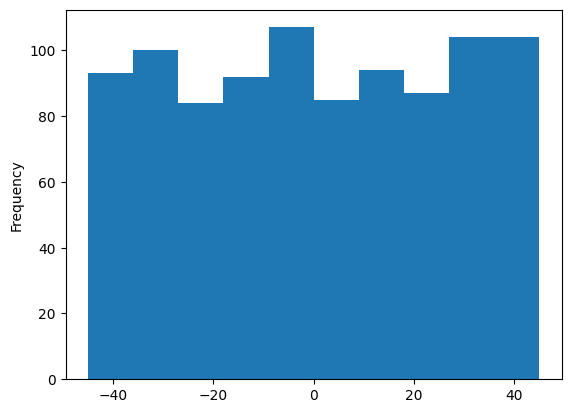

In [3]:
labels_df = pd.read_csv(csv_path)

labels_df['angle'].plot(kind='hist')

In [4]:
scaler = preprocessing.StandardScaler()
labels_df['angle_scaled'] = scaler.fit_transform(labels_df['angle'].values.reshape(-1, 1))

scaler.inverse_transform(labels_df['angle_scaled'][0].reshape(-1,1))

array([[-22.]])

In [5]:
labels_df.head(5)

,id,angle,angle_scaled
0,Image-0--22Image_1.jpg,-22,-0.832780
1,Image-0-38Image_10.png,38,1.431396
2,Image-0-30Image_11.jpg,30,1.129506
3,Image-0-25Image_12.JPG,25,0.940825
4,Image-0-29Image_13.png,29,1.091770


In [6]:
y_train = labels_df['angle_scaled'].values
y_train[:5]

array([-0.83277994,  1.43139637,  1.1295062 ,  0.94082484,  1.09176993])

In [7]:

X_train = []

for file_name in labels_df['id']:
    image = cv2.imread(os.path.join(images_path, file_name), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    # COMPUTING FFT
    f = cv2.dft(np.float32(image))
    fshift = np.fft.fftshift(f)
    f_abs = np.abs(fshift) + 1.0
    f_img = 20 * np.log(f_abs)
    
    X_train.append(f_img)

In [8]:
X_train = np.array(X_train)
X_train = X_train.reshape(len(X_train), IMG_HEIGHT, IMG_WIDTH, 1)
X_train /= 255

In [9]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1)))

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), 
                                   activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                   activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                   activation='relu', padding='same'))
model.add(tf.keras.layers.GlobalMaxPooling2D())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.linear))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss=tf.keras.losses.mean_absolute_error,
                metrics=[tf.keras.metrics.mean_squared_error])

In [10]:
hist = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    verbose=2)

Epoch 1/50
24/24 - 23s - loss: 0.8858 - mean_squared_error: 1.0421 - val_loss: 0.8318 - val_mean_squared_error: 0.9421 - 23s/epoch - 969ms/step
Epoch 2/50
24/24 - 5s - loss: 0.8830 - mean_squared_error: 1.0338 - val_loss: 0.8324 - val_mean_squared_error: 0.9468 - 5s/epoch - 215ms/step
Epoch 3/50
24/24 - 5s - loss: 0.8766 - mean_squared_error: 1.0150 - val_loss: 0.8319 - val_mean_squared_error: 0.9436 - 5s/epoch - 203ms/step
Epoch 4/50
24/24 - 5s - loss: 0.8772 - mean_squared_error: 1.0144 - val_loss: 0.8320 - val_mean_squared_error: 0.9466 - 5s/epoch - 203ms/step
Epoch 5/50
24/24 - 5s - loss: 0.8777 - mean_squared_error: 1.0162 - val_loss: 0.8301 - val_mean_squared_error: 0.9392 - 5s/epoch - 215ms/step
Epoch 6/50
24/24 - 5s - loss: 0.8775 - mean_squared_error: 1.0231 - val_loss: 0.8302 - val_mean_squared_error: 0.9440 - 5s/epoch - 202ms/step
Epoch 7/50
24/24 - 5s - loss: 0.8791 - mean_squared_error: 1.0217 - val_loss: 0.8265 - val_mean_squared_error: 0.9393 - 5s/epoch - 203ms/step
Epoc

<Axes: >

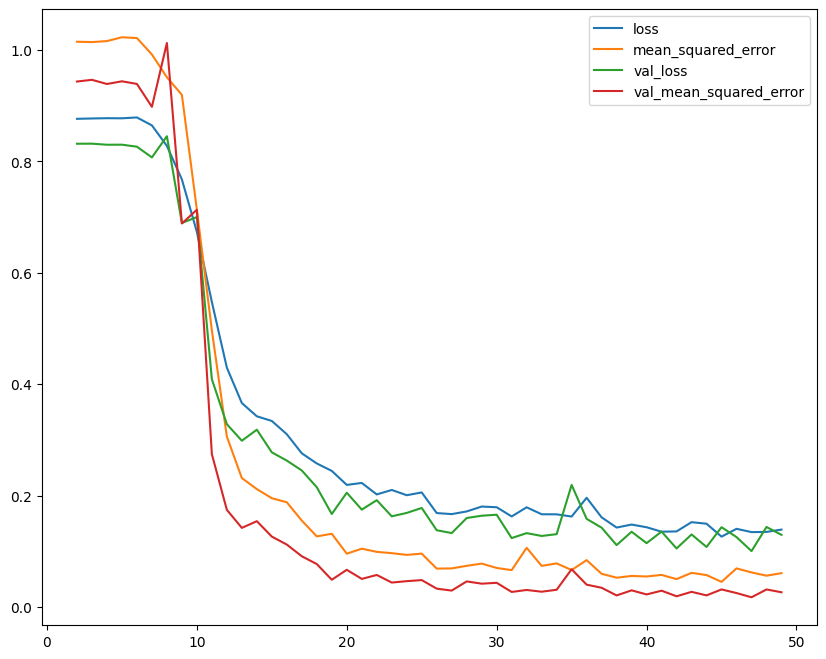

In [11]:
hist_df = pd.DataFrame(hist.history)
hist_df[2:].plot(figsize=(10, 8))

In [13]:
model.save('models/cnn_with_fft.h5')
dump(scaler, 'models/scaler.bin', compress=True)

['models/scaler.bin']